# Lens modeling with `lenstronomy`

Author(s): Ahmad Al - Imtiaz, Anowar J. Shajib, S M Rafee Adnan, Jobair Hasan

## Importing necessary libraries

In [1]:
# import of standard python libraries
import h5py
import corner
import joblib
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Util import mask_util
from lenstronomy.Util import util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

%matplotlib inline

d:\Study\Astronomy_Astrophysics\env_astro\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Loading image data

In [2]:
with h5py.File('DESIJ1624+0129_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.015933467783649957,
 'dec_at_xy_0': -5.159999999999995,
 'exposure_time': array([[387.83774, 441.16168, 542.47943, ..., 541.4656 , 447.01666,
         426.3097 ],
        [503.64996, 466.7774 , 414.55206, ..., 407.22598, 502.87936,
         452.1209 ],
        [416.88434, 449.0342 , 486.43555, ..., 600.1629 , 455.7515 ,
         389.8148 ],
        ...,
        [378.77472, 526.77496, 401.574  , ..., 361.43057, 251.7196 ,
         295.8367 ],
        [548.3277 , 365.50455, 468.689  , ..., 220.32043, 363.31458,
         285.76724],
        [397.7238 , 504.85352, 443.03714, ..., 415.66058, 271.3376 ,
         317.57083]], dtype=float32),
 'image_data': array([[-4.35694280e-03, -1.01454966e-02, -4.60426270e-03, ...,
          1.16039616e+00,  1.27829063e+00,  9.34593363e-01],
        [ 1.52079805e-03, -1.33007230e-02, -7.30407218e-03, ...,
          5.12736524e-01,  4.38811040e-01,  3.46899156e-01],
        [ 2.21416939e-02,  2.52265389e-02,  1.20261796e-02, ...,
     

## Loading PSF

In [3]:
with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

## Visualizing the image data

C:\Users\ahmad\AppData\Local\Temp\ipykernel_1884\608555511.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',


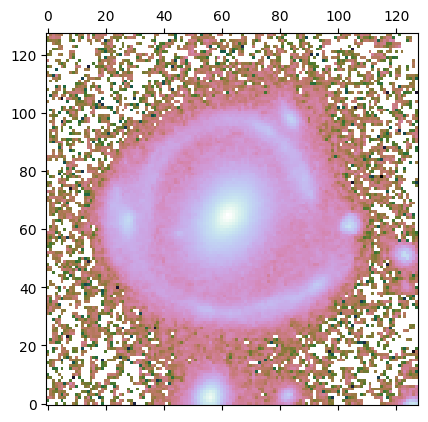

In [4]:
plt.matshow(np.log10(kwargs_data['image_data']), origin='lower',
            cmap='cubehelix');

## Masking

In [5]:
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.8 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(lens_center_ra,
                                      lens_center_dec,
                                      r,
                                      util.image2array(x_coords),
                                      util.image2array(y_coords))


mask_3clock_left = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-3.15,
                                   lens_center_dec-0.1,
                                   0.4, 0.4, 0)

mask_3clock_right = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-5,
                                   lens_center_dec-0.4,
                                   .75, 1.2, -3/4*np.pi)

mask_1clock_right = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.4,
                                   lens_center_dec+3.4,
                                   .75, 1.5, 3/4*np.pi)
mask_1clock_left = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra-1.,
                                   lens_center_dec+3.55,
                                   .75, 1.5, -1/3*np.pi)
mask_6clock = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+.5,
                                   lens_center_dec-4.7,
                                   1, 3, 0.55*np.pi)
mask_9clock_left = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+2.9,
                                   lens_center_dec-.2,
                                   .45, .3, np.pi/2)
mask_9clock_right = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+1.6,
                                   lens_center_dec-0.5,
                                   0.25, 0.25, 0)
        
mask = ((1 - mask_outer) * (1- mask_3clock_left)* (1- mask_3clock_right)* 
        (1- mask_6clock)*  (1 - mask_9clock_right)* (1 - mask_1clock_right)*
        (1 - mask_1clock_left) * (1 - mask_9clock_left))  
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = util.array2image(mask)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_1884\1995991559.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data['image_data'])*mask, origin='lower',


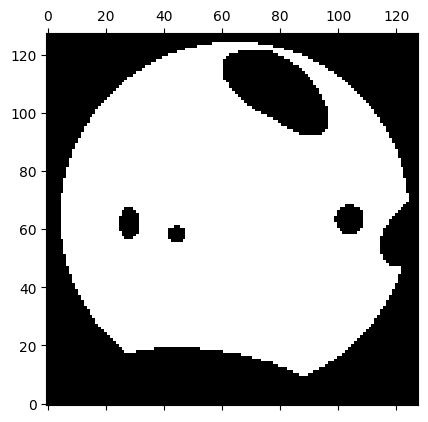

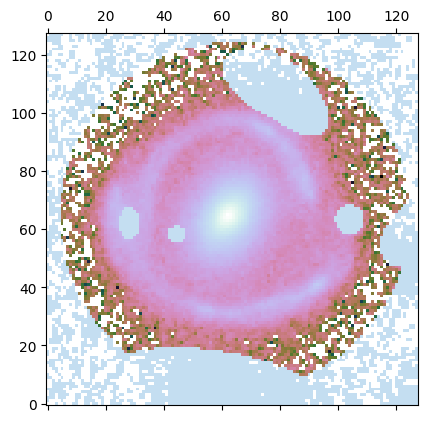

In [6]:
plt.matshow(mask, origin='lower', cmap='cubehelix')
plt.matshow(np.log10(kwargs_data['image_data'])*mask, origin='lower',
            cmap='cubehelix')

## Model Lists

In [7]:
lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

## Model Parameters

### Lens Galaxy's Mass Model

In [8]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# EPL
fixed_lens.append({'gamma': 1.8})
kwargs_lens_init.append({'theta_E': 2.7,
                         'gamma': 2.,
                         'e1': 0.0,
                         'e2': 0.0,
                         'center_x': 0.0,
                         'center_y': 0.0})
kwargs_lens_sigma.append({'theta_E': .2,
                          'gamma': .1,
                          'e1': 0.05,
                          'e2': 0.05,
                          'center_x': 0.5,
                          'center_y': 0.5})
kwargs_lower_lens.append({'theta_E': 0.01,
                          'gamma': 1.,
                          'e1': -0.5,
                          'e2': -0.5,
                          'center_x': -10,
                          'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10.,
                          'gamma': 3.,
                          'e1': 0.5,
                          'e2': 0.5,
                          'center_x': 10,
                          'center_y': 10})
# SHEAR
fixed_lens.append({'ra_0': 0,
                   'dec_0': 0,})
kwargs_lens_init.append({'gamma_ext': 0.2,
                         'psi_ext': 1,
                         'ra_0': 0,
                         'dec_0': 0})
kwargs_lens_sigma.append({'gamma_ext': 0.05,
                          'psi_ext': 0.1,
                          'ra_0': 0,
                          'dec_0': 0})
kwargs_lower_lens.append({'gamma_ext': 0,
                          'psi_ext': -np.pi/2,
                          'ra_0': -100,
                          'dec_0': -100})
kwargs_upper_lens.append({'gamma_ext': 0.4,
                         'psi_ext': np.pi/2,
                          'ra_0': 100,
                          'dec_0': 100})

### Source Galaxy's Light Model

In [9]:
# source galaxy's light model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# SERSIC_ELLIPSE
fixed_source.append({'n_sersic': 1.})
kwargs_source_init.append({'R_sersic': 0.05,
                           'n_sersic': 1,
                           'e1': 0,
                           'e2': 0,
                           'center_x': 0.,
                           'center_y': 0,
                           'amp': 1})
kwargs_source_sigma.append({'n_sersic': 0.5,
                            'R_sersic': 0.1,
                            'e1': 0.05,
                            'e2': 0.05,
                            'center_x': 0.2,
                            'center_y': 0.2,
                            'amp': 10})
kwargs_lower_source.append({'e1': -0.5,
                            'e2': -0.5,
                            'R_sersic': 0.001,
                            'n_sersic': .5,
                            'center_x': -10,
                            'center_y': -10,
                            'amp': 0})
kwargs_upper_source.append({'e1': 0.5,
                            'e2': 0.5,
                            'R_sersic': 0.2,
                            'n_sersic': 5.,
                            'center_x': 10,
                            'center_y': 10,
                            'amp': 100})

# SHAPELETS
fixed_source.append({'n_max': 10})
kwargs_source_init.append({'beta': 0.,
                           'center_x': 0.,
                           'center_y': 0.})
kwargs_source_sigma.append({'beta': 0.1,
                            'center_x': 0.2,
                            'center_y': 0.2})
kwargs_lower_source.append({'beta':0.01,
                            'center_x': -10,
                            'center_y': -10})
kwargs_upper_source.append({'beta':0.1,
                            'center_x': 10,
                            'center_y': 10})

### Lens Galaxy's Light Model

In [10]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# First sersic
fixed_lens_light.append({'n_sersic': 1.})
kwargs_lens_light_init.append({'R_sersic': 0.5,
                               'n_sersic': 2,
                               'e1': 0,
                               'e2': 0,
                               'center_x': 0.,
                               'center_y': 0,
                               'amp': 1})
kwargs_lens_light_sigma.append({'n_sersic': 1,
                                'R_sersic': 0.3,
                                'e1': 0.05,
                                'e2': 0.05,
                                'center_x': 0.1,
                                'center_y': 0.1,
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5,
                                'e2': -0.5,
                                'R_sersic': 0.001,
                                'n_sersic': .5,
                                'center_x': -10,
                                'center_y': -10,
                                'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5,
                                'e2': 0.5,
                                'R_sersic': 10,
                                'n_sersic': 5.,
                                'center_x': 10,
                                'center_y': 10,
                                'amp': 100})


# Second sersic
fixed_lens_light.append({'n_sersic': 4.})
kwargs_lens_light_init.append({'R_sersic': 1,
                               'n_sersic': 2,
                               'e1': 0,
                               'e2': 0,
                               'center_x': 0.,
                               'center_y': 0,
                               'amp': 16})
kwargs_lens_light_sigma.append({'n_sersic': 1,
                                'R_sersic': 0.3,
                                'e1': 0.05,
                                'e2': 0.05,
                                'center_x': 0.1,
                                'center_y': 0.1,
                                'amp': 10})
kwargs_lower_lens_light.append({'e1': -0.5,
                                'e2': -0.5,
                                'R_sersic': 0.001,
                                'n_sersic': .5,
                                'center_x': -10,
                                'center_y': -10,
                                'amp': 0})
kwargs_upper_lens_light.append({'e1': 0.5,
                                'e2': 0.5,
                                'R_sersic': 10,
                                'n_sersic': 5.,
                                'center_x': 10,
                                'center_y': 10,
                                'amp': 100})

### Combining Parameters

In [11]:
joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]
joint_lens_light_with_lens_light = [[0, 1, ['center_x', 'center_y']]]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens,
               kwargs_lower_lens, kwargs_upper_lens]


source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]

# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {
    'joint_source_with_source': joint_source_with_source,
    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light
    }

In [12]:
kwargs_likelihood = {'check_bounds': True,
                     'image_likelihood_mask_list': [mask],
                     'check_positive_flux': True}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

#### Combining all the information to be sent to lenstronomy

In [13]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'}

## The model fiting

In [14]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood,
                              kwargs_params)
                              
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100,
                                'n_iterations': 200}],
                       #['MCMC', {'n_burn': 200, 'n_run': 800, 'n_walkers':
                        #200, 'sigma_scale': .1}]
                    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.01884391078508 reduced X^2 of best position
-4917.959557359581 log likelihood
9654 effective number of data points
[{'theta_E': 2.753902114896325, 'gamma': 1.8, 'e1': -0.08211306931806181, 'e2': 0.018888294896573215, 'center_x': 0.09382179883016475, 'center_y': 0.15196369203222543}, {'gamma_ext': 0.0476182884460343, 'psi_ext': 1.0470168301626896, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.19708333948246115, 'n_sersic': 1.0, 'e1': 0.3254024226304476, 'e2': 0.027891006229287366, 'center_x': 0.1426938493365387, 'center_y': 0.007317752180819558}, {'amp': 1, 'n_max': 10, 'beta': 0.09958907658658617, 'center_x': 0.1426938493365387, 'center_y': 0.007317752180819558}] source result
[{'amp': 1, 'R_sersic': 0.5130728800827431, 'n_sersic': 1.0, 'e1': -0.08309968971986274, 'e2': -0.18647842100660497, 'center_x': 0.16854837149359433, 'center_y': 0.00496

### Joblib File

In [15]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1624+0129_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)
# joblib.load("DESIJ0201-2739_pso_output.joblib")

## Visualizing the fitted model

-1.0094334043953495 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0094334043952067


d:\Study\Astronomy_Astrophysics\env_astro\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
d:\Study\Astronomy_Astrophysics\env_astro\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
d:\Study\Astronomy_Astrophysics\env_astro\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


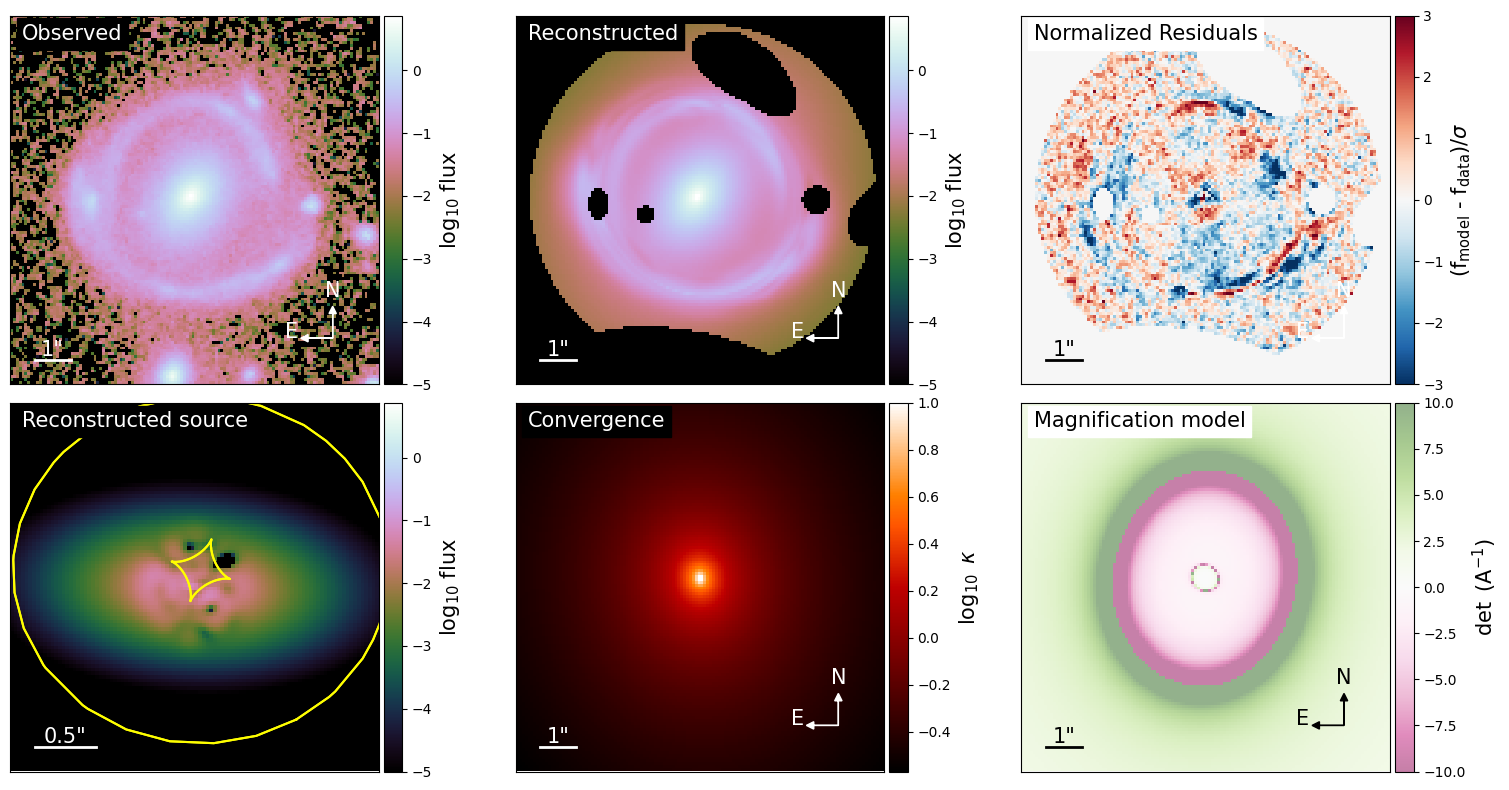

d:\Study\Astronomy_Astrophysics\env_astro\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


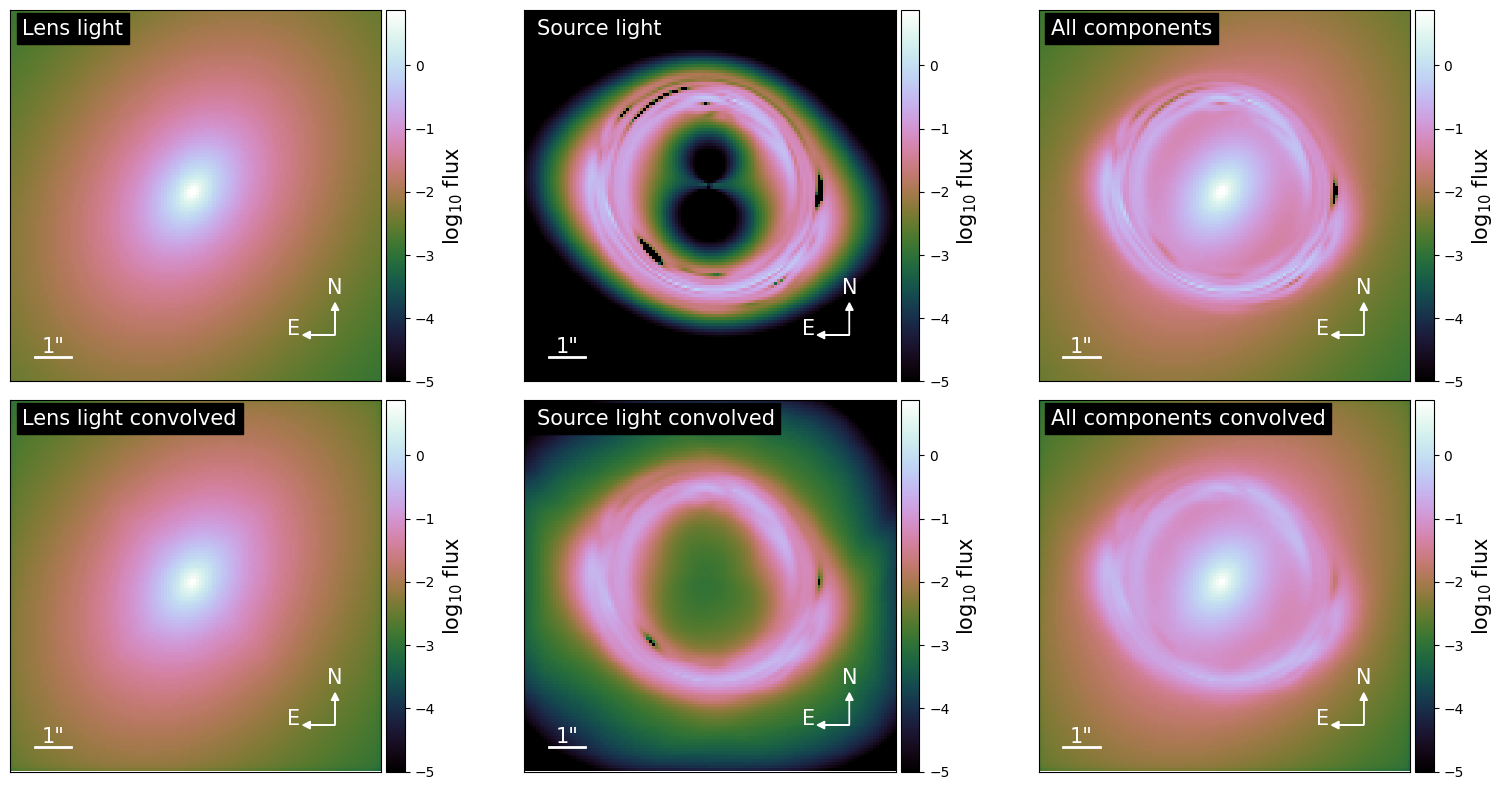

{'kwargs_lens': [{'theta_E': 2.753902114896325, 'gamma': 1.8, 'e1': -0.08211306931806181, 'e2': 0.018888294896573215, 'center_x': 0.09382179883016475, 'center_y': 0.15196369203222543}, {'gamma_ext': 0.0476182884460343, 'psi_ext': 1.0470168301626896, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 66.84970708962192, 'R_sersic': 0.19708333948246115, 'n_sersic': 1.0, 'e1': 0.3254024226304476, 'e2': 0.027891006229287366, 'center_x': 0.1426938493365387, 'center_y': 0.007317752180819558}, {'amp': array([-370.15203114,   15.6149051 ,  -10.81649376,  -77.05187772,
         14.96560253,   40.38262283,   13.14216078,  -16.36549377,
         -6.6906693 ,   -1.26437075,  -49.85405551,    8.26428308,
        -19.33187312,  -10.95912769,  -44.72174797,   20.38349116,
          7.07506691,    6.49651723,   -0.69327935,   10.1377052 ,
          1.68855463,   -6.08105288,    9.50940315,    5.91104309,
          3.86042545,    0.41522989,    9.95872776,   23.35559737,
         10.47016451,    5.26156

In [16]:
model_plot = ModelPlot(
    multi_band_list, kwargs_model, kwargs_result,
    arrow_size=0.02, cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.03, with_caustics=True,
                        scale_size=0.5, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None,
                  wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light',
                             lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved',
                             lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light',
                             source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved',
                             source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components',
                             source_add=True, lens_light_add=True,
                             unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved',
                             source_add=True, lens_light_add=True,
                             point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None,
                  wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

#### visualizing the MCMC chain, if run

number of non-linear parameters in the MCMC process:  15
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  160000
160000


/tmp/ipykernel_4673/1527950566.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


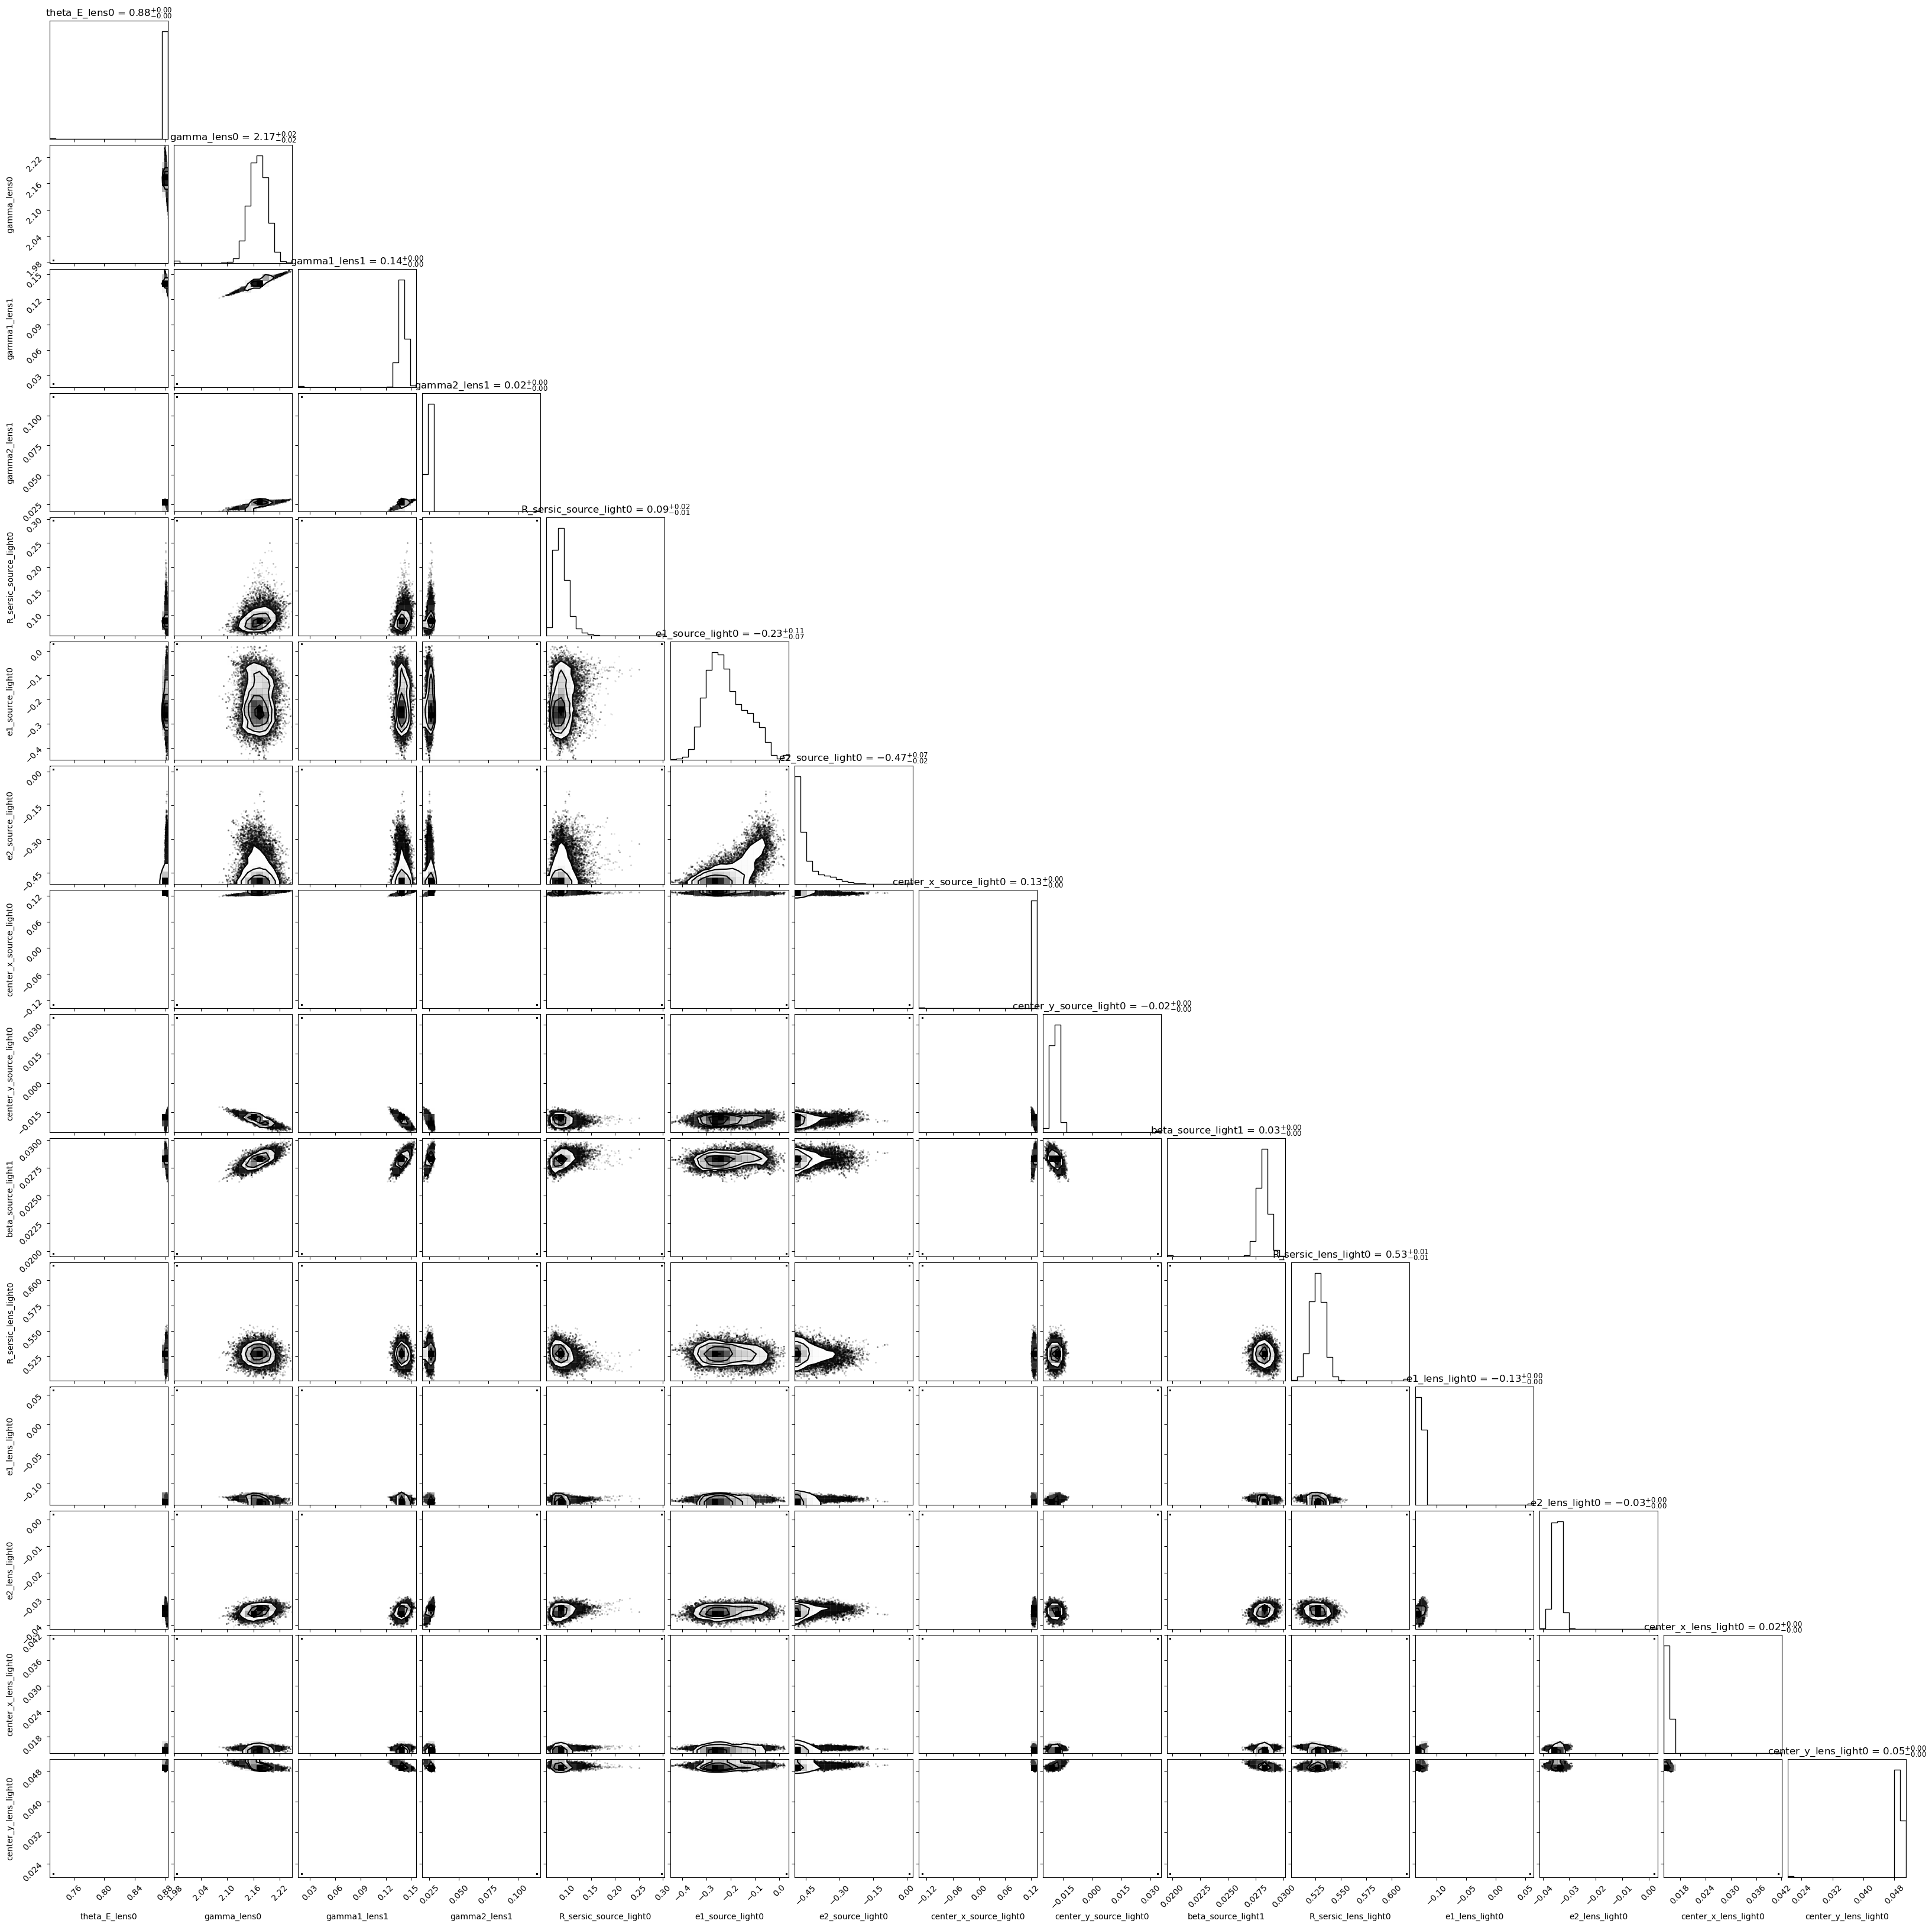

In [38]:
if len(chain_list) >= 1:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

    param_class = fitting_seq.param_class

    print("number of non-linear parameters in the MCMC process: ",
          len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ",
          np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
    if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc_cut)
        plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:],
                             show_titles=True)